In [1]:
#standard libraries
import pandas as pd
import numpy as np
import re
import pickle
from unidecode import unidecode
import matplotlib.pyplot as plt

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

#nltk
import nltk
from nltk.corpus import stopwords
from collections import Counter
from langdetect import detect

#preprocessing and feature extraction
import helper

#tensorflow
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import FeatureSpace

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import random
random.seed(42)

In [2]:
df = pd.read_csv('data/online_ship_listing_data.csv')

In [3]:
#splitting the dataframe
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1184 train examples
296 validation examples
370 test examples


In [4]:
train.shape

(1184, 16)

In [5]:
val.shape

(296, 16)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, 904 to 143
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1184 non-null   int64  
 1   name           1184 non-null   object 
 2   price          1184 non-null   float64
 3   location       1184 non-null   object 
 4   offerer        1184 non-null   object 
 5   id             1184 non-null   int64  
 6   description    1184 non-null   object 
 7   year           1184 non-null   int64  
 8   manufacturer   1184 non-null   object 
 9   model          1181 non-null   object 
 10  category       1184 non-null   object 
 11  length         1184 non-null   float64
 12  fuel_type      1115 non-null   object 
 13  hull_material  1184 non-null   object 
 14  hull_shape     243 non-null    object 
 15  country        1184 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory usage: 157.2+ KB


In [7]:
def df_to_dataset(df, shuffle=True, batch_size=32):
    df = df.copy()
    
    df = helper.preprocess_df(df)
    df, all_cols = helper.create_features(df)
    labels = df.pop('price')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds, all_cols

In [8]:
#convert dataframe to dataset
batch_size = 32
train_ds, all_cols = df_to_dataset(train)
val_ds, _ = df_to_dataset(val, shuffle=False, batch_size=batch_size)

C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['word_count'], axis=1, inplace=True)
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_language'] = df['description'].apply(lambda x:detect(x))
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [9]:
#sanity checking
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of fuel tank:', feature_batch['fuel_type'])
    print('A batch of country:', feature_batch['country'])
    print('A batch of model:', feature_batch['category'])
    print('A batch of targets:', label_batch)

Every feature: ['year', 'model', 'category', 'length', 'fuel_type', 'hull_material', 'country', 'noun_counts', 'verb_counts', 'adjective_counts', 'bilge_pump', 'deck_finish', 'fuel_tank', 'good_condition', 'level_indicator', 'material_grp', 'sailing_yacht', 'stainless_steel', 'tank_litre', 'teak_cockpit', 'avg_price_by_hull_material', 'avg_price_by_fuel_type', 'avg_price_by_category']
A batch of fuel tank: tf.Tensor(
[b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel' b'diesel'
 b'diesel' b'diesel' b'petrol' b'diesel' b'diesel' b'diesel' b'diesel'
 b'diesel' b'diesel' b'diesel' b'petrol' b'diesel' b'diesel' b'diesel'
 b'diesel' b'diesel' b'diesel' b'petrol' b'diesel' b'diesel' b'diesel'
 b'diesel' b'diesel' b'diesel' b'diesel'], shape=(32,), dtype=string)
A batch of country: tf.Tensor(
[b'italy' b'netherlands' b'afghanistan' b'spain' b'afghanistan'
 b'afghanistan' b'afghanistan' b'germany' b'greece' b'germany'
 b'afghanistan' b'italy' b'afghanistan' b'netherlands' b'afghanista

In [10]:
fileName = 'model/column_names.pkl'
with open(fileName,'wb') as f:
    pickle.dump(all_cols,f)

In [11]:
float_normalized_cols = ['length', 'noun_counts', 'verb_counts', 'adjective_counts', 'avg_price_by_hull_material',
                        'avg_price_by_fuel_type', 'avg_price_by_category']
float_cols = ['bilge_pump', 'deck_finish', 'fuel_tank', 'level_indicator', 'material_grp', 'mehr_anzeigen',
             'sailing_yacht', 'stainless_steel', 'tank_litre', 'teak_cockpit']
string_categorical_cols = ['model', 'category', 'hull_material', 'country', 'fuel_type']
float_discretized_cols = ['year']

float_normalized = 'float_normalized'
just_float = 'float'
string_categorical = 'string_categorical'
float_discretized = 'float_discretized'

In [12]:
all_keys = sorted(float_normalized_cols + float_cols + string_categorical_cols)
features_dict = {key: float_normalized if key in float_normalized_cols else (just_float if key in float_cols else string_categorical) for key in all_keys}

In [13]:
features_dict['year'] = FeatureSpace.float_discretized(num_bins=10)

In [14]:
features_dict

{'adjective_counts': 'float_normalized',
 'avg_price_by_category': 'float_normalized',
 'avg_price_by_fuel_type': 'float_normalized',
 'avg_price_by_hull_material': 'float_normalized',
 'bilge_pump': 'float',
 'category': 'string_categorical',
 'country': 'string_categorical',
 'deck_finish': 'float',
 'fuel_tank': 'float',
 'fuel_type': 'string_categorical',
 'hull_material': 'string_categorical',
 'length': 'float_normalized',
 'level_indicator': 'float',
 'material_grp': 'float',
 'mehr_anzeigen': 'float',
 'model': 'string_categorical',
 'noun_counts': 'float_normalized',
 'sailing_yacht': 'float',
 'stainless_steel': 'float',
 'tank_litre': 'float',
 'teak_cockpit': 'float',
 'verb_counts': 'float_normalized',
 'year': <keras.src.utils.feature_space.Feature at 0x1e330811510>}

In [15]:
feature_space = FeatureSpace(
    features={
    "adjective_counts": 'float_normalized',
    "avg_price_by_category": 'float_normalized',
    "avg_price_by_fuel_type": 'float_normalized',
    "avg_price_by_hull_material": 'float_normalized',
    "bilge_pump": 'float',
    "category": 'string_categorical',
    "country": 'string_categorical',
    "deck_finish": 'float',
    "fuel_tank": 'float',
    "fuel_type": 'string_categorical',
    "hull_material": 'string_categorical',
    "length": 'float_normalized',
    "level_indicator": 'float',
    "material_grp": 'float',
    "good_condition": 'float',
    "model": 'string_categorical',
    "noun_counts": 'float_normalized',
    "sailing_yacht": 'float',
    "stainless_steel": 'float',
    "tank_litre": 'float',
    "teak_cockpit": 'float',
    "verb_counts": 'float_normalized',
    "year": FeatureSpace.float_discretized(num_bins=10)
    },
    output_mode="concat",
    crosses=[
        FeatureSpace.cross(feature_names=("model", "category"), crossing_dim=64),
        FeatureSpace.cross(feature_names=("hull_material", "category"), crossing_dim=16),
        FeatureSpace.cross(feature_names=("fuel_type", "category"), crossing_dim=16),
        
    ],
)

#needs to adapt the feature_space. Reminder: feature_space needs to be adapted to a dataset WITHOUT LABEL
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [16]:
feature_space.save('model/feature_space.keras')

In [17]:
#checking the dataset shape
for x, _ in train_ds.take(1):
    preprocessed_x = feature_space(x)
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (32, 956)
preprocessed_x.dtype: <dtype: 'float32'>


In [18]:
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [19]:
#remapping to label
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

#To make sure the training data is read infinitely
preprocessed_train_ds = preprocessed_train_ds.repeat()

preprocessed_val_ds = val_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

In [20]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()
x = keras.layers.Dense(32, activation="relu")(encoded_features)
x = keras.layers.Dropout(0.5)(x) #using dropout layer to avoid overfitting
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(1, activation="linear")(x)

#1st model: training_model
training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="mse", metrics=[rmse, "mse"]
)

#2nd model: inference_model
inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [21]:
TRAIN_BATCH_SIZE = 32 
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 500
NUM_EVAL_EXAMPLES = 14906

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
#early stopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [22]:
#training the model
history = training_model.fit(preprocessed_train_ds,
                    validation_data=preprocessed_val_ds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping]
                    )

Epoch 1/500
18/18 [==============================] - 1s 26ms/step - loss: 57669656576.0000 - rmse: 237559.3594 - mse: 57669656576.0000 - val_loss: 70600376320.0000 - val_rmse: 261060.8750 - val_mse: 70600376320.0000
Epoch 2/500
18/18 [==============================] - 0s 19ms/step - loss: 50857299968.0000 - rmse: 224704.3438 - mse: 50857299968.0000 - val_loss: 70469836800.0000 - val_rmse: 260818.4688 - val_mse: 70469836800.0000
Epoch 3/500
18/18 [==============================] - 0s 16ms/step - loss: 55515230208.0000 - rmse: 232858.2500 - mse: 55515230208.0000 - val_loss: 68260470784.0000 - val_rmse: 256675.4531 - val_mse: 68260470784.0000
Epoch 4/500
18/18 [==============================] - 0s 17ms/step - loss: 49710137344.0000 - rmse: 219768.1562 - mse: 49710137344.0000 - val_loss: 50541539328.0000 - val_rmse: 220835.0469 - val_mse: 50541539328.0000
Epoch 5/500
18/18 [==============================] - 0s 17ms/step - loss: 28693653504.0000 - rmse: 168000.9688 - mse: 28693653504.0000 -

18/18 [==============================] - 0s 18ms/step - loss: 4863305728.0000 - rmse: 67615.1875 - mse: 4863305728.0000 - val_loss: 7602630656.0000 - val_rmse: 84485.8906 - val_mse: 7602630656.0000
Epoch 40/500
18/18 [==============================] - 0s 17ms/step - loss: 5105281024.0000 - rmse: 70063.6172 - mse: 5105281024.0000 - val_loss: 7599771648.0000 - val_rmse: 84397.3203 - val_mse: 7599771648.0000
Epoch 41/500
18/18 [==============================] - 0s 14ms/step - loss: 5584182784.0000 - rmse: 71945.3828 - mse: 5584182784.0000 - val_loss: 7051827200.0000 - val_rmse: 81401.2344 - val_mse: 7051827200.0000
Epoch 42/500
18/18 [==============================] - 0s 14ms/step - loss: 5343994368.0000 - rmse: 71515.7344 - mse: 5343994368.0000 - val_loss: 8028894720.0000 - val_rmse: 86715.4219 - val_mse: 8028894720.0000
Epoch 43/500
18/18 [==============================] - 0s 16ms/step - loss: 5037155840.0000 - rmse: 69566.3281 - mse: 5037155840.0000 - val_loss: 8194133504.0000 - val_rm

In [23]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right');    

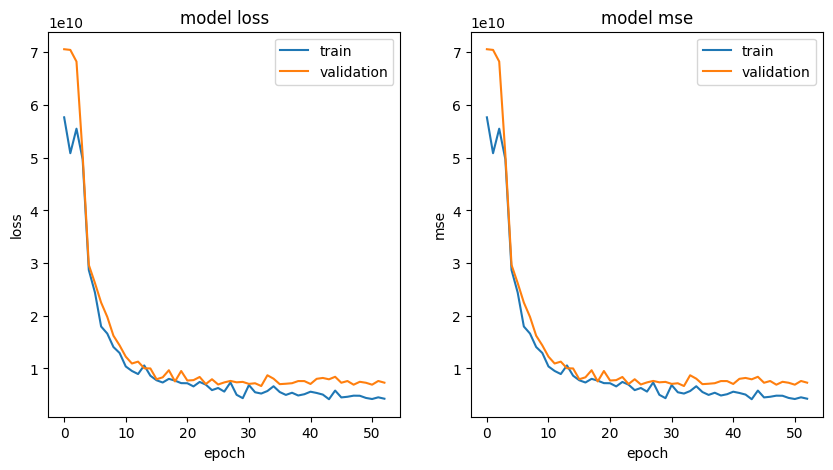

In [24]:
plot_curves(history, ['loss', 'mse'])

In [25]:
#creating a sample data
sample = {
    "year":tf.convert_to_tensor([2010.]),
    "model":tf.convert_to_tensor(['gulet']),
    "category":tf.convert_to_tensor(['schoner']),
    "length":tf.convert_to_tensor([83.]),
    "fuel_type":tf.convert_to_tensor(['diesel']),
    "hull_material":tf.convert_to_tensor(['steel']),
    "country":tf.convert_to_tensor(['turkey']),
    "noun_counts":tf.convert_to_tensor([20.]),
    "verb_counts":tf.convert_to_tensor([20.]),
    "adjective_counts":tf.convert_to_tensor([20.]),
    "bilge_pump":tf.convert_to_tensor([1.]),
    "deck_finish":tf.convert_to_tensor([0.]),
    "fuel_tank":tf.convert_to_tensor([1.]),
    "level_indicator":tf.convert_to_tensor([1.]),
    "material_grp":tf.convert_to_tensor([0.]),
    "good_condition":tf.convert_to_tensor([0.]),
    "sailing_yacht":tf.convert_to_tensor([1.]),
    "stainless_steel":tf.convert_to_tensor([0.]),
    "tank_litre":tf.convert_to_tensor([1.]),
    "teak_cockpit":tf.convert_to_tensor([1.]),
    "avg_price_by_hull_material":tf.convert_to_tensor([173764.8396226415]),
    "avg_price_by_fuel_type":tf.convert_to_tensor([172121.64462209304]),
    "avg_price_by_category":tf.convert_to_tensor([476125.0]),
    
}

In [26]:
from tensorflow.keras.models import save_model, load_model

In [27]:
inference_model.save("model/inference_model.keras")
reconstructed_model = load_model("model/inference_model.keras")
reconstructed_model.predict(sample)

1/1 [==============================] - 0s 370ms/step


array([[2769858.8]], dtype=float32)

In [28]:
test_temp = helper.preprocess_df(test)
df_test,_ = helper.create_features(test_temp)

C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['word_count'], axis=1, inplace=True)
C:\Online Course\Projects\shipping-listing-price-prediction\helper.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_language'] = df['description'].apply(lambda x:detect(x))


In [29]:
test_price = df_test.price.tolist()
df_test.drop('price', axis=1,inplace=True)

In [30]:
list_of_dicts = [row.to_dict() for _, row in df_test.iterrows()]

In [31]:
predicted_price = []
for i in list_of_dicts:
    #convert the value of the dictionary to tensor
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in i.items()}
    predictions = inference_model.predict(input_dict)
    predicted_price.append(predictions[0][0])

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 32ms/step


In [32]:
from sklearn.metrics import mean_squared_error

#appending the quantity and predicted quantity to the dataframe
df_test['price'] = test_price
df_test['predicted_price'] = predicted_price
rmse = np.sqrt(mean_squared_error(df_test['price'], df_test['predicted_price']))

print('The resulting RMSE for the test dataset is: ', rmse)

The resulting RMSE for the test dataset is:  69515.71667369918
